## Importing Data and Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import tensorflow as tf

import copy
import time

In [ ]:
# Loading the FashionMNIST data
train_set = torchvision.datasets.FashionMNIST("./data", download=True, train=True)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False)
X_train = train_set.data.numpy()
y_train = train_set.targets.numpy()
X_test = test_set.data.numpy()
y_test = test_set.targets.numpy()

100%|██████████| 26421880/26421880 [00:00<00:00, 118181126.63it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4642424.16it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 58530769.98it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5209234.50it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Pre-processing Data: Cleaning, Equalizing, and LabelEncoding

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
meanValue = np.mean(X_train)
stdValue = np.std(X_train)

X_train = (X_train - meanValue) / stdValue
X_test = (X_test - meanValue) / stdValue

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


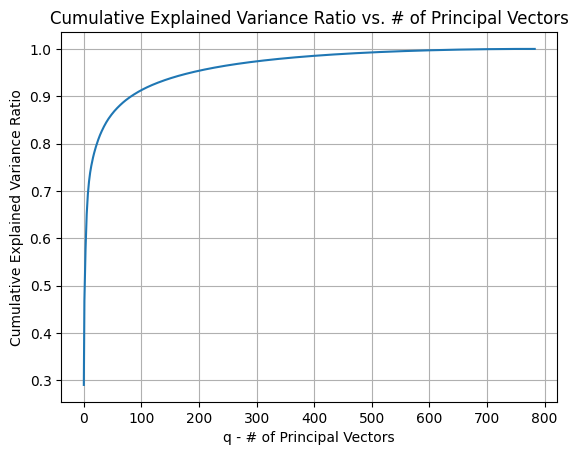

# of principal vectors for 90.0% of the variance: 84


In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

varianceRatio = np.cumsum(pca.explained_variance_ratio_)
threshold = 0.90

principalVectors = np.argmax(varianceRatio >= threshold) + 1
X_train_reduced = X_train_pca[:, :principalVectors]
X_test_reduced = X_test_pca[:, :principalVectors]

plt.plot(varianceRatio)
plt.xlabel('q - # of Principal Vectors')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. # of Principal Vectors')
plt.grid(True)
plt.show()
print(f'# of principal vectors for {threshold*100}% of the variance: {principalVectors}')

## Model Construction and Training

In [ ]:
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, num_features, num_classes, l2=0.0):
        super(MultinomialLogisticRegression, self).__init__()
        self.layer1 = nn.Linear(num_features, num_classes)
        self.l2 = l2

    def forward(self, x):
        out = self.layer1(x)
        return out

In [ ]:
def resetWeights(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            layer.reset_parameters()

def trainModel(model, epochs, lossFn, X_train, X_test, y_train, y_test, lr=0.01, batchSize=32, decisionThreshold=0.5):
    trainAcc, testAcc = np.zeros(epochs), np.zeros(epochs)
    trainErr, testErr = np.zeros(epochs), np.zeros(epochs)
    trainLoss, testLoss = np.zeros(epochs), np.zeros(epochs)
    batchCount = 0

    resetWeights(model)
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
          batchCount += 1
          output = model(batch_X)
          loss = lossFn(output.squeeze(), batch_y)
          loss.backward()

          with torch.no_grad():
              for param in model.parameters():
                  param.data -= lr * param.grad

              model.zero_grad()

          with torch.no_grad():
              trainLoss[epoch] += loss.item()
              _, trainPredictions = torch.max(output, 1)
              trainError = torch.mean((trainPredictions != batch_y).float())

              output = model(X_test)
              loss = lossFn(output.squeeze(), y_test)

              testLoss[epoch] += loss.item()
              _, testPredictions = torch.max(output, 1)
              testError = torch.mean((testPredictions != y_test).float())

              trainErr[epoch] += trainError.item()
              testErr[epoch] += testError.item()
              trainAcc[epoch] += 1 - trainError.item()
              testAcc[epoch] += 1 - testError.item()

    trainAcc = trainAcc/(batchCount/epochs)
    testAcc = testAcc/(batchCount/epochs)
    trainErr = trainErr/(batchCount/epochs)
    testErr = testErr/(batchCount/epochs)
    trainLoss = trainLoss/(batchCount/epochs)
    testLoss = testLoss/(batchCount/epochs)

    return trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss


X_train_tensor = torch.tensor(X_train_reduced).float()
y_train_tensor = torch.tensor(y_train).long()
X_test_tensor = torch.tensor(X_test_reduced).float()
y_test_tensor = torch.tensor(y_test).long()

## Grid Search Analysis

In [ ]:
epochs_list = [50, 100, 250]
learning_rates = [1, 0.5, 0.05]
batchSizes = [4096]
lambdas = [0, 0.001, 0.1]
trainedModels = []

num_features = X_train_tensor.shape[1]
num_classes = len(set(y_train))
lossFn = nn.CrossEntropyLoss()

for lambda_ in lambdas:
  model = MultinomialLogisticRegression(num_features, num_classes, l2=lambda_)
  for batchSize in batchSizes:
    for lr in learning_rates:
        for epochs in epochs_list:
          startTime = time.time()
          trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss = trainModel(
              model,
              epochs,
              lossFn,
              X_train_tensor,
              X_test_tensor,
              y_train_tensor,
              y_test_tensor,
              lr=lr,
              batchSize=batchSize
          )
          trainingTime = time.time() - startTime
          trainedModels.append({ 'model': copy.deepcopy(model),
                                'hyperparameters': {'epochs': epochs, 'lr': lr, 'batchSize': batchSize, 'lambda': lambda_ },
                                'trainingStats': { 'testAcc': testAcc[-1], 'trainAcc': trainAcc[-1],
                                                    'testError': testErr[-1], 'trainError': trainErr[-1],
                                                    'testLoss': testLoss[-1], 'trainLoss': trainLoss[-1] },
                                'trainingTime': trainingTime
                                })
          print(f'Completed epochs, lr, batchSize, lambda, test error: {epochs}, {lr}, {batchSize}, {lambda_}, --- {testAcc[-1]}')

Completed epochs, lr, batchSize, lambda, test error: 50, 1, 4096, 0, --- 0.7563799987236659
Completed epochs, lr, batchSize, lambda, test error: 100, 1, 4096, 0, --- 0.7824533343315124
Completed epochs, lr, batchSize, lambda, test error: 250, 1, 4096, 0, --- 0.7830000003178914
Completed epochs, lr, batchSize, lambda, test error: 50, 0.5, 4096, 0, --- 0.7935533334811529
Completed epochs, lr, batchSize, lambda, test error: 100, 0.5, 4096, 0, --- 0.7888266672690709
Completed epochs, lr, batchSize, lambda, test error: 250, 0.5, 4096, 0, --- 0.7764666636784872
Completed epochs, lr, batchSize, lambda, test error: 50, 0.05, 4096, 0, --- 0.8251133312781652
Completed epochs, lr, batchSize, lambda, test error: 100, 0.05, 4096, 0, --- 0.8298733323812485
Completed epochs, lr, batchSize, lambda, test error: 250, 0.05, 4096, 0, --- 0.8336000005404155
Completed epochs, lr, batchSize, lambda, test error: 50, 1, 4096, 0.001, --- 0.7754733353853226
Completed epochs, lr, batchSize, lambda, test error: 10

# Finding the best model that maximizes accuracy


In [ ]:
globalOptimalModel = None
globalOptimalLoss = None
globalOptimalAcc = None

for model_ in trainedModels:
    optimalAcc = model_['trainingStats']['testAcc']
    optimalLoss = model_['trainingStats']['testLoss']

    if (globalOptimalLoss == None):
      globalOptimalLoss = optimalLoss
      globalOptimalAcc = optimalAcc
      globalOptimalModel = model_
    elif (optimalAcc > globalOptimalAcc):
      globalOptimalLoss = optimalLoss
      globalOptimalAcc = optimalAcc
      globalOptimalModel = model_
    elif (optimalAcc == globalOptimalAcc and optimalLoss < globalOptimalLoss):
      globalOptimalLoss = optimalLoss
      globalOptimalAcc = optimalAcc
      globalOptimalModel = model_

print(globalOptimalModel)

{'model': MultinomialLogisticRegression(
  (layer1): Linear(in_features=84, out_features=10, bias=True)
), 'hyperparameters': {'epochs': 250, 'lr': 0.05, 'batchSize': 4096, 'lambda': 0.1}, 'trainingStats': {'testAcc': 0.8344933340946833, 'trainAcc': 0.8474840770165125, 'testError': 0.16550666590531668, 'trainError': 0.15251592298348746, 'testLoss': 0.47712032596270243, 'trainLoss': 0.4401133378346761}, 'trainingTime': 266.73853635787964}


In [ ]:
gLr = globalOptimalModel['hyperparameters']['lr']
gEpochs = globalOptimalModel['hyperparameters']['epochs']
gBatchSize = globalOptimalModel['hyperparameters']['batchSize']
gLambda = globalOptimalModel['hyperparameters']['lambda']

print(f'Global Optimal Model Hyperparameters: lr={gLr}, epochs={gEpochs}, batchSize={gBatchSize}, lamda={gLambda}')
print(f'Global Optimal Acc: {globalOptimalAcc}, Global Optimal Loss: {globalOptimalLoss}')

Global Optimal Model Hyperparameters: lr=0.05, epochs=250, batchSize=4096, lamda=0.1
Global Optimal Acc: 0.8344933340946833, Global Optimal Loss: 0.47712032596270243


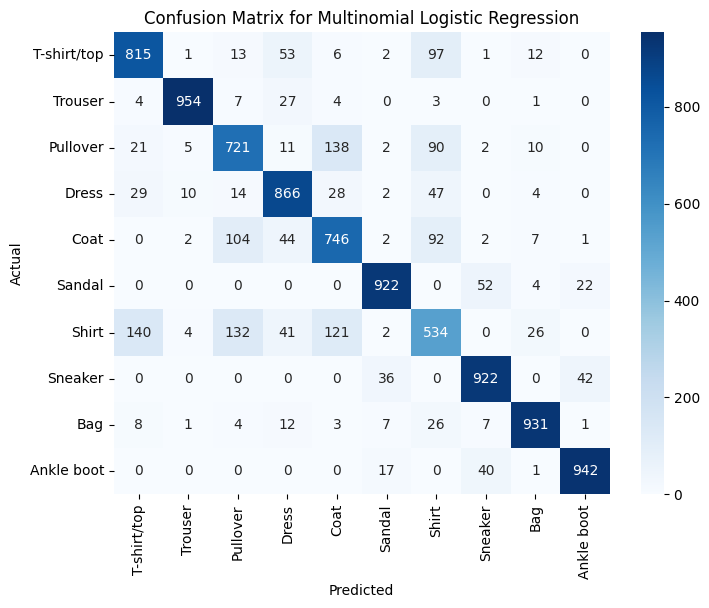

Precision: 0.8335291897614938, Recall: 0.8353, F1: 0.8340858897599166


In [ ]:
gModel = globalOptimalModel['model']
with torch.no_grad(): output = gModel(X_test_tensor)
_, testPredictions = torch.max(output, 1)
y_true = np.array(y_test_tensor)
y_pred = np.array(testPredictions)
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
labels = class_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Multinomial Logistic Regression')
plt.show()

print(f'Precision: {precision}, Recall: {recall}, F1: {f1}')

### Reproducability Test & Visualization

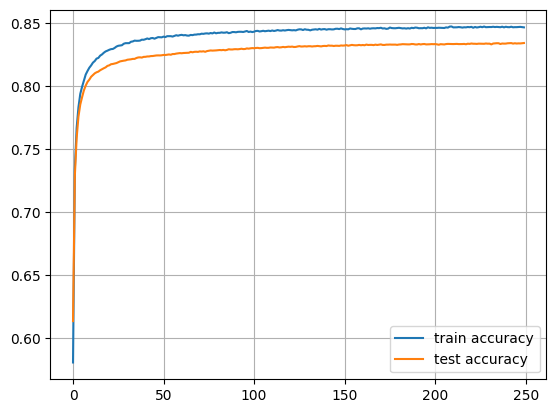

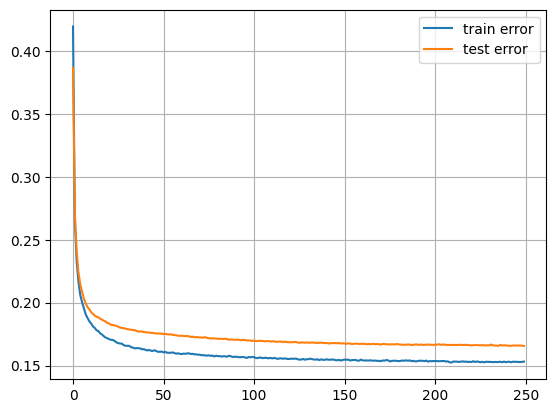

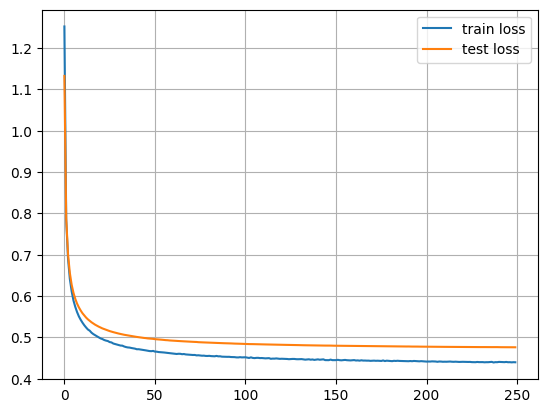

Train Accuracy: 0.8468559781710306, Train Error: 0.15314402182896933, Train Loss: 0.44008870124816896
Test Accuracy: 0.8343999991814296, Test Error: 0.16560000081857046, Test Loss: 0.476353923479716


In [ ]:
lr = globalOptimalModel['hyperparameters']['lr']
epochs = globalOptimalModel['hyperparameters']['epochs']
batchSize = globalOptimalModel['hyperparameters']['batchSize']
lambda_ = globalOptimalModel['hyperparameters']['lambda']

num_features = X_train_tensor.shape[1]
num_classes = len(set(y_train))
lossFn = nn.CrossEntropyLoss()
model = MultinomialLogisticRegression(num_features, num_classes, l2=lambda_)
lossFn = nn.CrossEntropyLoss()

trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss = trainModel(
    model,
    epochs,
    lossFn,
    X_train_tensor,
    X_test_tensor,
    y_train_tensor,
    y_test_tensor,
    lr=lr,
    batchSize=batchSize
)

model.eval()

plt.plot(trainAcc, label='train accuracy')
plt.plot(testAcc, label='test accuracy')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(trainErr, label='train error')
plt.plot(testErr, label='test error')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(trainLoss, label='train loss')
plt.plot(testLoss, label='test loss')
plt.grid(True)
plt.legend()

plt.show()

print(f'Global Optimal Model Hyperparameters: lr={lr}, epochs={epochs}, batchSize={batchSize}, lamda={lambda_}')
print(f'Train Accuracy: {trainAcc[-1]}, Train Error: {trainErr[-1]}, Train Loss: {trainLoss[-1]}')
print(f'Test Accuracy: {testAcc[-1]}, Test Error: {testErr[-1]}, Test Loss: {testLoss[-1]}')

## Time Complexity Analysis

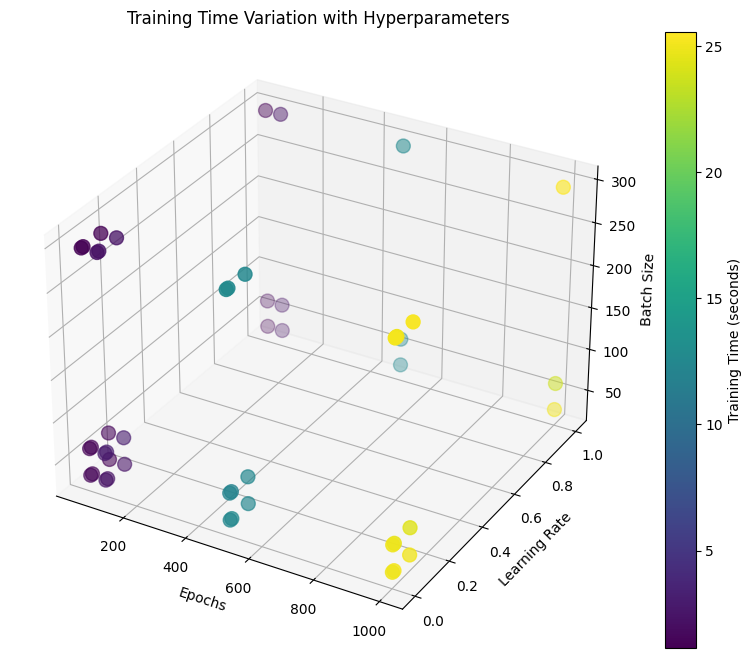

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

lambdaValue = 0.001
filteredModels = [modelInfo for modelInfo in trainedModels if modelInfo['hyperparameters']['lambda'] == lambdaValue]

# Extract hyperparameters and training time
epochsList = [modelInfo['hyperparameters']['epochs'] for modelInfo in filteredModels]
learningRates = [modelInfo['hyperparameters']['lr'] for modelInfo in filteredModels]
batchSizes = [modelInfo['hyperparameters']['batchSize'] for modelInfo in filteredModels]
trainingTimes = [modelInfo['trainingTime'] for modelInfo in filteredModels]

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color based on training time
sc = ax.scatter(epochsList, learningRates, batchSizes, c=trainingTimes, cmap='viridis', marker='o', s=100)

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Batch Size')
ax.set_title('Training Time Variation with Hyperparameters')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Training Time (seconds)')

plt.show()
